<h1 align="center">PSL Week - Topological Data Analysis</h1>
<h1 align="center">Practice 2: TDA for supervised and unsupervised learning</h1>

In this practical session, we will use the various TDA tools presented in class in order to run data science tasks (inference, clustering, classification) on a data set of 3D shapes. As in the first practical session, we will use  [`Gudhi`](https://gudhi.inria.fr/) (see first practical session for installation instructions). The different sections of this notebook can be run independently (except Section 0 which is mandatory), so feel free to start with the project that sounds the more interesting to you :-)

Note also that if you choose to switch from a section to another, make sure to clear all variables first (and run Section 0 again) since some variable names are shared between sections.

In [129]:
import gudhi as gd
import gudhi.representations as gdr
print(gd.__version__)

3.11.0


Other than that, you are free to use whatever other Python package you feel comfortable with :-) We make some suggestions below (these dependencies are also required to run our solutions to the exercises). 

In [54]:
import os
import sys

We will use three standard Python libraries: `NumPy`, `Scipy` and `Matplotlib`.

In [55]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [56]:
%matplotlib inline

When computing vectorizations and performing supervised machine learning and deep learning tasks, we will use various modules of [`Scikit-Learn`](https://scikit-learn.org/stable/index.html).  

In [57]:
import sklearn.preprocessing   as skp
import sklearn.neighbors       as skn
import sklearn.model_selection as skm
import sklearn.decomposition   as skd
import sklearn.manifold        as skf
import sklearn.pipeline        as skl
import sklearn.svm             as sks
import sklearn.ensemble        as ske

## Data set manipulation

We are good to go! First things first, we have to download the data set. It can be obtained [here](https://www.math.ens.psl.eu/~eaamari/teaching/2025-2026/PSL_Week/labeledDb.7z). Extract it, and save its path in the `dataset_path` variable.

In [58]:
dataset_path = './LabeledDB_new/'

As you can see, the data set in split in several categories (`Airplane`, `Human`, `Teddy`, etc), each category having its own folder. Inside each folder, some 3D shapes (i.e., 3D triangulations) are provided in [`.off`](https://en.wikipedia.org/wiki/OFF_(file_format)) format, and face (i.e., triangle) labels are provided in text files (extension `.txt`). 

Every data science project begins by some preprocessing ;-) 

### Question 1.
Open one of the `.off` files and explore its structure. You will notice it is a text file with a format like this
```plaintext
OFF
5619 11234 16851
0.00579 -0.038323 0.995163
-0.007929 -0.042864 0.997353
0.010348 -0.020546 0.983874
...
-0.004916 0.226141 -0.919991
0.01083 0.248499 -0.930961
0.000868 0.253122 -0.929906
3 5613 5616 5614
3 5615 5616 5613
3 5612 5615 5613
...
3 3 1 0
3 0 5 2
3 0 1 9
3 8 0 9
```
The first line after `OFF` contains the number of vertices, the number of faces and the total number of lines in the file. Then follows the list of all the vertices coordinates, followed by the list of faces encoded as
```plaintext
n_edges vertex_1 vertex_2 ... vertex_n
```
You will note that here `n_edges` will always be 3.

Write a function `off2numpy` that opens an `.off` file, extracts all the relevant information and stores it in two `NumPy` arrays, called `vertices` (type float and shape number_of_vertices x 3---the 3D coordinates of the vertices) and `faces` (type integer and shape number_of_faces x 3---the IDs of the vertices that create faces). 

In [59]:
def off2numpy(shape_name):
    with open(shape_name, 'r') as S:
        S.readline()
        num_vertices, num_faces, _ = [int(n) for n in S.readline().split(' ')]
        info = S.readlines()
    vertices = np.array([[float(coord) for coord in l.split(' ')] for l in info[0:num_vertices]])
    faces    = np.array([[int(coord) for coord in l.split(' ')[1:]] for l in info[num_vertices:]])
    return vertices, faces

### Question 2.
Similarly, open  file `..._labels.txt` to explore its structure. You will see a structure like
```plaintext
label_1
f_11 f_12 ... f_1N
label_2
f_21 f_22 ... f_2N
...
```
Each pair of lines contains the title of the label followed by the list of face indices corresponding to that label.

**WARNING: The faces are indexed starting from 1, make sure you shift all indices by 1 to match 0-based indexing as does Python.**

Write a function `get_labels` that fills the `L` array with the label name of each face and returns it. In other words, `L` is a string array where `L[i]` is the label of face `i`.

In [60]:
def get_labels(label_name, num_faces):
    L = np.empty([num_faces], dtype='|S100')
    with open(label_name, 'r') as S:
        info = S.readlines()
    labels, face_indices = info[0::2], info[1::2]
    for ilab, lab in enumerate(labels):
        indices = [int(f)-1 for f in face_indices[ilab].split(' ')[:-1]]
        L[  np.array(indices)  ] = lab[:-1]
    return L

### Question 3.
Use the helper functions `load_data` and `plot_data` to load the data from any file you want and plot the meshcorresponding to the loaded model.
Note that `load_data` uses your previously defined `get_labels` and `off2numpy` functions, this will allow you to validate the implementation you provided.

In [84]:
def load_data(category: str, object_id: int, noise_level: float = 0.0):
    vertices, faces = off2numpy(dataset_path + f'{category}/{object_id}.off')
    label_faces = get_labels(dataset_path + f'{category}/{object_id}_labels.txt', len(faces))
    noisy_vertices = vertices + np.random.randn(*vertices.shape) * noise_level
    return noisy_vertices, faces, label_faces

def face2points(vals_faces, faces, num_vertices):
    vals_points = np.empty([num_vertices], dtype=type(vals_faces))
    for iface, face in enumerate(faces):
        vals_points[face] = vals_faces[iface]
    return vals_points

def plot_data(vertices, faces, label_faces):
    # convert face labels to point labels and encode them
    point_labels = face2points(label_faces, faces, len(vertices))
    color_vals = skp.LabelEncoder().fit_transform(point_labels)

    fig = go.Figure(data=go.Mesh3d(
        x=vertices[:,0], y=vertices[:,1], z=vertices[:,2],
        i=faces[:,0].astype(int), j=faces[:,1].astype(int), k=faces[:,2].astype(int),
        intensity=color_vals,
        colorscale='Viridis',
        showscale=True,
        flatshading=True,
        opacity=1.0
    ))

    fig.update_layout(scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ), margin=dict(l=0, r=0, b=0, t=30), title='3D shape colored by face labels (point-wise)')

    fig.show()

In [85]:
vertices, faces, label_faces = load_data('Airplane', 61)
plot_data(vertices, faces, label_faces)

### Question 4.
For the same model you chose, load the data using `load_data` but this time add a small noise level (e.g. 0.01) and plot again the data. Observe how the mesh is affected as the noise level increases.

In [87]:
noisy_vertices, faces, label_faces = load_data('Airplane', 61, noise_level=0.01)
plot_data(noisy_vertices, faces, label_faces)

## 3D shape classification with persistence diagrams

In this section, our goal is to use persistence diagrams for classifying and segmenting 3D shapes with supervised machine learning. We will use the structure of the data folder to inform us about the general class of each file.

In [64]:
all_categories = os.listdir(dataset_path)
print(all_categories)

['Bird', 'Armadillo', 'Bust', 'Chair', 'Ant', 'Table', 'Mech', 'Human', 'Bearing', 'Glasses', 'Vase', 'Plier', 'Cup', 'Hand', 'FourLeg', 'Airplane', 'Octopus', 'Teddy', 'Fish']


Let's start with classification. We will compute persistence diagrams for all shapes in different categories, and train a classifier from `Scikit-Learn` to predict the category from the persistence diagrams.

### Question 1.

Since `Gudhi` requires simplex trees from the persistence diagram computations, write a `get_simplex_tree_from_faces` function that builds a simplex tree from the faces of a given 3D shape triangulation.

In [65]:
def get_simplex_tree_from_faces(faces):
    simplex_tree = gd.SimplexTree()
    for face in faces:
        simplex_tree.insert(face, -1e10)
    return simplex_tree

### Question 2.
Write a function `compute_persistence_diagram_from_data` which uses `load_data`, builds the simplex tree from the faces, assigns a filtration value to the simplexes corresponding to the third coordinate of the vertices, and returns the persistence diagram for the 0th order homology. Make sure the filtration is consistent

In [66]:
def compute_persistence_diagram_from_data(category: str, object_id: int, noise_level: float = 0.0):
    vertices, faces, label_faces = load_data(category, object_id, noise_level)
    st = get_simplex_tree_from_faces(faces)
    filtration = vertices[:,2]
    for v in range(len(vertices)):
        st.assign_filtration([v], filtration[v])
    st.make_filtration_non_decreasing()
    st.persistence()
    return st.persistence_intervals_in_dimension(0)

As discussed in class, it is not very convenient to use persistence diagrams directly for machine learning purposes (except for a few methods such as $K$-nearest neighbors). What we need is to define a vectorization, that is, a map $\Phi:\mathcal{D}\rightarrow\mathcal{H}$ sending persistence diagrams into a Hilbert space, or equivalently,  a symmetric kernel function $k:\mathcal{D}\times \mathcal{D} \rightarrow \mathbb{R}$ such that $k(D,D')=\langle \Phi(D),\Phi(D')\rangle$. Fortunately, there are already a bunch of such maps and kernels in `Gudhi` :-)

You can check the documentation here https://gudhi.inria.fr/python/latest/representations.html for any quesion on `gdr` classes and usage.

In the following we will compute and visualize the most popular kernels on some persistence diagrams. We will also study their properties with respect to noisy versions of the dataset.

In [88]:
def load_full_dataset(noise_level: float = 0.0):
    """
        Loads the dataset of persistence diagrams with the given noise level on the vertices.
        Returns a pair containing
        - `dgms` (list): List of persistence diagrams.
        - `labels` (list): List of labels corresponding to the diagrams.
        - `le` (LabelEncoder): Label encoder fitted on the categories.
    """
    dgms, labels = [], []
    for label in all_categories:
        for object_id in map(lambda x: int(x[:-4]), filter(lambda x: x.endswith('.off'), os.listdir(dataset_path + label + '/'))):
            dgm = compute_persistence_diagram_from_data(label, int(object_id), noise_level)
            dgms.append(dgm)
            labels.append(label)
    le = skp.LabelEncoder().fit(labels)
    return dgms, labels, le

In [89]:
dgms_clean, labels_clean, le_clean = load_full_dataset()
dgms_little_noisy, labels_little_noisy, le_little_noisy = load_full_dataset(0.01)
dgms_very_noisy, labels_very_noisy, le_very_noisy = load_full_dataset(0.05)

### Question 3.
Pick any index of your choice, and extract the corresponding diagrams into the variables. Plot each diagram to see how the noise affects it.

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

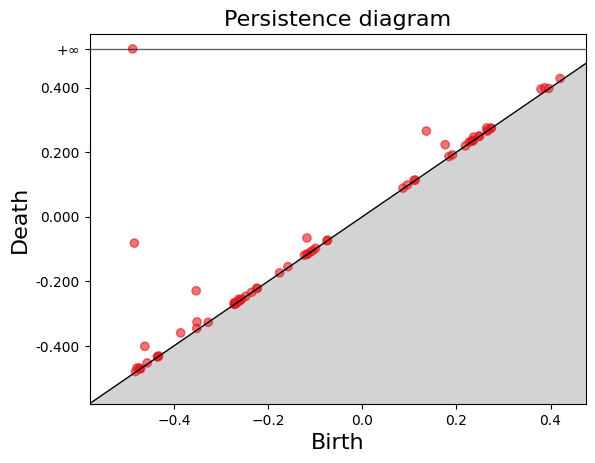

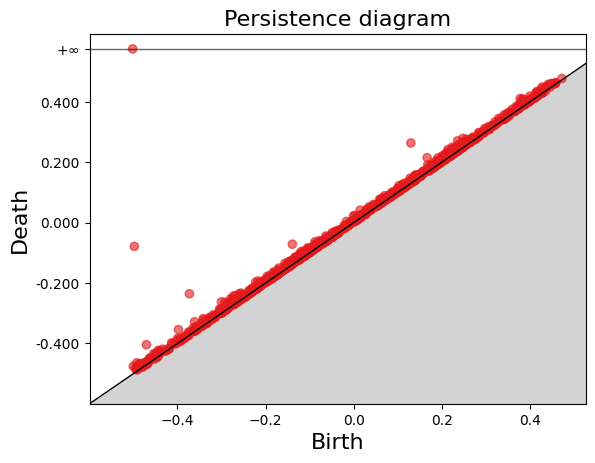

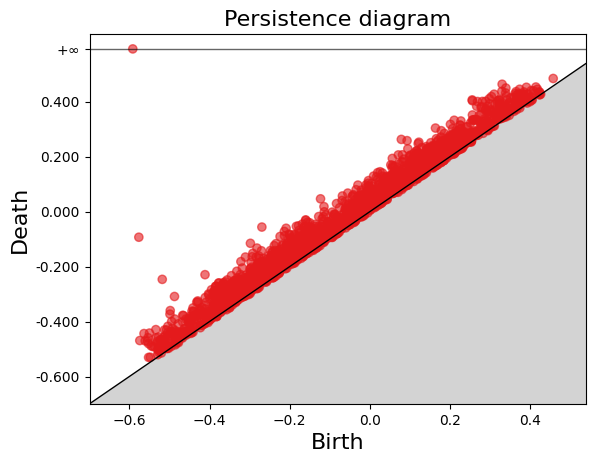

In [90]:
dgm_index = 30

raw_clean_diagram = dgms_clean[dgm_index]
gd.plot_persistence_diagram(raw_clean_diagram)

raw_little_noisy_diagram = dgms_little_noisy[dgm_index]
gd.plot_persistence_diagram(raw_little_noisy_diagram)

raw_very_noisy_diagram = dgms_very_noisy[dgm_index]
gd.plot_persistence_diagram(raw_very_noisy_diagram)

### Question 4.

Use the `DiagramSelector` API and its `transform` method to transform the diagrams for clean, little noisy and very noisy to remove its points with infinite coordinates. (Check [here](https://gudhi.inria.fr/python/latest/representations.html#gudhi.representations.preprocessing.DiagramSelector))

In [70]:
clean_diagram = gdr.DiagramSelector(use=True, point_type='finite').transform([raw_clean_diagram])[0]
little_noisy_diagram = gdr.DiagramSelector(use=True, point_type='finite').transform([raw_little_noisy_diagram])[0]
very_noisy_diagram = gdr.DiagramSelector(use=True, point_type='finite').transform([raw_very_noisy_diagram])[0]

Now, let's see what `Gudhi` has to offer to vectorize persistence diagrams with `Scikit-Learn` estimator-like classes, that is, with classes that have `fit`, `transform`, and `fit_transform` methods, see [this article](https://arxiv.org/pdf/1309.0238.pdf) for more details. For each vectorization mentioned below, we recommend you to play with its parameters and infer their influence on the ouput in order to get some intuition. 

The first vectorization method that was introduced historically is the persistence landscape. A persistence landscape is basically obtained by rotating the persistence diagram by $-\pi/4$
(so that the diagonal becomes the $x$-axis), and then putting tent functions on each point. The $k$th landscape is then defined as the $k$th largest value among all these tent functions. It is eventually turned into a vector by evaluating it on a bunch of uniformly sampled points on the $x$-axis.

### Question 5.
Use the class `gdr.Landscape` and its `fit_transform` method to compute the first landscape of the persistence diagram for a resolution of 1000 and a number of landscapes of 3. Use te function `plot_landscape` to visualize it. Do it for the clean, littl noisy and very noisy diagram. How des the noise affect the landscapes?

In [91]:
num_landscapes = 3

def compute_landscape(clean_diagram, little_noisy_diagram, very_noisy_diagram, resolution):    
    # Create landscape estimator with current resolution
    LS = gdr.Landscape(resolution=resolution, num_landscapes=num_landscapes)
    
    # Compute landscapes for current resolution
    L_clean = LS.fit_transform([clean_diagram])
    L_little_noisy = LS.fit_transform([little_noisy_diagram])
    L_very_noisy = LS.fit_transform([very_noisy_diagram])

    return L_clean, L_little_noisy, L_very_noisy

### Question 6.
Using the function below, explore the effect of the resolution on the landscapes. What are the pros and cons of a high resolution and how would you visually choose the best resolution? Are you able to estimate the general level of noise from the landscapes?

In [92]:
def create_interactive_landscape_resolution_plot_combined(clean_diagram, little_noisy_diagram, very_noisy_diagram, 
                                                        min_resolution=50, max_resolution=1000, num_steps=20):
    """
    Create an interactive Plotly figure with a slider to control the landscape resolution.
    All landscape functions are displayed in the same subplot for each noise level.
    Uses logarithmic scale for resolution values.
    
    Parameters:
    -----------
    clean_diagram, little_noisy_diagram, very_noisy_diagram : array-like
        The three persistence diagrams to compare
    min_resolution, max_resolution : int
        Range of resolution values for the persistence landscapes
    num_steps : int
        Number of steps in the slider
    """
    
    # Create resolution values using logarithmic scale
    log_min = np.log10(min_resolution)
    log_max = np.log10(max_resolution)
    log_resolutions = np.linspace(log_min, log_max, num_steps)
    resolutions = np.round(10**log_resolutions).astype(int)
    
    # Remove duplicates while preserving order
    _, unique_indices = np.unique(resolutions, return_index=True)
    resolutions = resolutions[np.sort(unique_indices)]
    
    # Create subplots - one row, three columns for each noise level
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=["Clean", "Little Noisy", "Very Noisy"],
        horizontal_spacing=0.1
    )
    
    # Store all traces for different resolution values
    trace_index = 0
    trace_map = []  # maps slider step → list of trace indices to show
    
    # Define colors for different landscape functions
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']
    
    for i, resolution in enumerate(resolutions):
        current_visible_traces = []

        L_clean, L_little_noisy, L_very_noisy = compute_landscape(clean_diagram, little_noisy_diagram, very_noisy_diagram, resolution)

        num_landscapes = len(L_clean[0]) // resolution
        
        # Reshape landscapes to separate each landscape function
        landscape_clean = L_clean[0].reshape((num_landscapes, -1))
        landscape_little_noisy = L_little_noisy[0].reshape((num_landscapes, -1))
        landscape_very_noisy = L_very_noisy[0].reshape((num_landscapes, -1))
        
        # Add traces for each landscape function and each noise level
        for nl in range(num_landscapes):
            # Clean diagram - landscape function nl
            fig.add_trace(go.Scatter(
                y=landscape_clean[nl],
                mode='lines',
                name=f'λ{nl+1}',
                line=dict(color=colors[nl % len(colors)], width=2),
                visible=(i == 0),
                showlegend=(i == 0)  # Only show legend for first resolution
            ), row=1, col=1)
            current_visible_traces.append(trace_index)
            trace_index += 1
            
            # Little noisy diagram - landscape function nl
            fig.add_trace(go.Scatter(
                y=landscape_little_noisy[nl],
                mode='lines',
                name=f'λ{nl+1}',
                line=dict(color=colors[nl % len(colors)], width=2),
                visible=(i == 0),
                showlegend=False
            ), row=1, col=2)
            current_visible_traces.append(trace_index)
            trace_index += 1
            
            # Very noisy diagram - landscape function nl
            fig.add_trace(go.Scatter(
                y=landscape_very_noisy[nl],
                mode='lines',
                name=f'λ{nl+1}',
                line=dict(color=colors[nl % len(colors)], width=2),
                visible=(i == 0),
                showlegend=False
            ), row=1, col=3)
            current_visible_traces.append(trace_index)
            trace_index += 1
        
        trace_map.append(current_visible_traces)
    
    # Create slider steps with logarithmic spacing
    steps = []
    total_traces = trace_index
    
    for i, resolution in enumerate(resolutions):
        visible = [False] * total_traces
        
        # Enable traces for current slider step
        for idx in trace_map[i]:
            visible[idx] = True
        
        steps.append(dict(
            method="update",
            args=[{"visible": visible},
                  {"title": f"Persistence Landscapes Comparison - Resolution: {resolution} (log scale)"}],
            label=f"{resolution}"
        ))
    
    # Add slider
    fig.update_layout(
        sliders=[dict(
            steps=steps,
            currentvalue={"prefix": "Resolution: "},
            active=0,
            # Add some styling to indicate logarithmic scale
            len=0.8,
            x=0.1,
            y=0,
            xanchor="left",
            yanchor="top"
        )],
        height=500,
        showlegend=True,
        title="Interactive Persistence Landscapes with Resolution Control (Logarithmic Scale)",
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1.02
        ),
        annotations=[
            dict(
                x=0.5, y=-0.15,
                xref='paper', yref='paper',
                text="Resolution values are logarithmically spaced",
                showarrow=False,
                font=dict(size=10, color="gray")
            )
        ]
    )
    
    # Update axes labels
    fig.update_yaxes(title_text="Landscape Value")
    
    return fig

In [93]:
# Create and display the interactive landscape resolution plot with logarithmic scale
fig_landscape_resolution_combined = create_interactive_landscape_resolution_plot_combined(
    clean_diagram, little_noisy_diagram, very_noisy_diagram,
    min_resolution=5, max_resolution=1000, num_steps=15
)
fig_landscape_resolution_combined.show()

### Question 5.
A variation, called the silhouette, takes a weighted average of these tent functions instead. Here, we weight each tent function by the distance of the corresponding point to the diagonal. Write a function `compute_silhouettes` that uses the `Silhouette` API from `gdr` and its `fit_transform` method to compute the silhouette for each noisy version of the previously selected diagram, using a resolution of 1000, and returns the triple `clean_silhouette`, `little_noisy_silhouette` and `very_noisy_silhouette`.

In [94]:
def compute_silhouettes(clean_diagram, little_noisy_diagram, very_noisy_diagram, exponent):
    weight_function = lambda x: np.power(x[1]-x[0], exponent)
    SH = gdr.Silhouette(resolution=1000, weight=weight_function)
    sh_clean = SH.fit_transform([clean_diagram])
    sh_little_noisy = SH.fit_transform([little_noisy_diagram])
    sh_very_noisy = SH.fit_transform([very_noisy_diagram])
    return sh_clean, sh_little_noisy, sh_very_noisy

### Question 6.
Using the function below, explore the effect of the exponent in the weight function on the silouhettes and how it compares to the landscapes. What do you observe? What are the pros and cons of having high values of the exponent?

In [95]:
def create_interactive_silhouette_plot(clean_diagram, little_noisy_diagram, very_noisy_diagram, 
                                     min_exp=0, max_exp=3, num_steps=31):
    """
    Create an interactive Plotly figure with a slider to control the weight function exponent.
    
    Parameters:
    -----------
    clean_diagram, little_noisy_diagram, very_noisy_diagram : array-like
        The three persistence diagrams to compare
    min_exp, max_exp : float
        Range of exponents for the weight function
    num_steps : int
        Number of steps in the slider
    """
    
    # Create exponent values for the slider
    exponents = np.linspace(min_exp, max_exp, num_steps)
    
    # Create subplots
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=("Clean", "Little Noisy", "Very Noisy"),
        horizontal_spacing=0.1
    )
    
    # Store all traces for different exponent values
    trace_index = 0
    trace_map = []  # maps slider step → list of trace indices to show
    
    for i, exp in enumerate(exponents):
        current_visible_traces = []
        
        # Compute silhouettes for current exponent
        sh_clean, sh_little_noisy, sh_very_noisy = compute_silhouettes(clean_diagram, little_noisy_diagram, very_noisy_diagram, exp)
        
        # Add traces for each subplot
        # Clean diagram
        fig.add_trace(go.Scatter(
            y=sh_clean[0],
            mode='lines',
            name=f'Clean (exp={exp:.2f})',
            line=dict(color='blue', width=2),
            visible=(i == 0)
        ), row=1, col=1)
        current_visible_traces.append(trace_index)
        trace_index += 1
        
        # Little noisy diagram
        fig.add_trace(go.Scatter(
            y=sh_little_noisy[0],
            mode='lines',
            name=f'Little Noisy (exp={exp:.2f})',
            line=dict(color='orange', width=2),
            visible=(i == 0)
        ), row=1, col=2)
        current_visible_traces.append(trace_index)
        trace_index += 1
        
        # Very noisy diagram
        fig.add_trace(go.Scatter(
            y=sh_very_noisy[0],
            mode='lines',
            name=f'Very Noisy (exp={exp:.2f})',
            line=dict(color='red', width=2),
            visible=(i == 0)
        ), row=1, col=3)
        current_visible_traces.append(trace_index)
        trace_index += 1
        
        trace_map.append(current_visible_traces)
    
    # Create slider steps
    steps = []
    total_traces = trace_index
    
    for i, exp in enumerate(exponents):
        visible = [False] * total_traces
        
        # Enable traces for current slider step
        for idx in trace_map[i]:
            visible[idx] = True
        
        steps.append(dict(
            method="update",
            args=[{"visible": visible},
                  {"title": f"Silhouette Comparison - Weight Exponent: {exp:.2f}"}],
            label=f"{exp:.2f}"
        ))
    
    # Add slider
    fig.update_layout(
        sliders=[dict(
            steps=steps,
            currentvalue={"prefix": "Exponent: "},
            active=0
        )],
        height=500,
        showlegend=False,
        title="Interactive Silhouette Comparison with Weight Function Exponent Control"
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Resolution Index")
    fig.update_yaxes(title_text="Silhouette Value")
    
    return fig

In [96]:
# Create and display the interactive plot
fig = create_interactive_silhouette_plot(clean_diagram, little_noisy_diagram, very_noisy_diagram)
fig.show()

### Question 7.
The second method is the persistence image. A persistence image is obtained by rotating by $-\pi/4$, centering Gaussian functions on all diagram points (usually weighted by a parameter function, such as, e.g., the squared distance to the diagonal) and summing all these Gaussians. This gives a 2D function, that is pixelized into an image. Using `PersistenceImage` API and its `fit_transform` method, create a function `compute_persistence_image` which computes and returns the image for each of the diagrams. Use an image range of `[-.5, .5, 0, .5]` and a resolution of `[100, 100]`.

In [97]:
def compute_persistence_image(clean_diagram, little_noisy_diagram, very_noisy_diagram, bandwidth):
    # Create persistence image estimator with current bandwidth
    PI = gdr.PersistenceImage(bandwidth=bandwidth, im_range=[-0.5, 0.5, 0, 0.5], resolution=[100, 100])
    
    # Compute persistence images for current bandwidth
    pi_clean = PI.fit_transform([clean_diagram])
    pi_little_noisy = PI.fit_transform([little_noisy_diagram])
    pi_very_noisy = PI.fit_transform([very_noisy_diagram])

    return pi_clean, pi_little_noisy, pi_very_noisy

### Question 8.
Using the function below, explore the effects of the bandwidth on the persistence images. What do you observe and what are the pros and cons of large bandwidths?

In [98]:
def create_interactive_persistence_image_plot(clean_diagram, little_noisy_diagram, very_noisy_diagram, 
                                            min_bandwidth=0.01, max_bandwidth=0.2, num_steps=20):
    """
    Create an interactive Plotly figure with a slider to control the persistence image bandwidth.
    
    Parameters:
    -----------
    clean_diagram, little_noisy_diagram, very_noisy_diagram : array-like
        The three persistence diagrams to compare
    min_bandwidth, max_bandwidth : float
        Range of bandwidth values for the persistence images
    num_steps : int
        Number of steps in the slider
    """
    
    # Create bandwidth values for the slider
    bandwidths = np.linspace(min_bandwidth, max_bandwidth, num_steps)
    
    # Create subplots
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=("Clean", "Little Noisy", "Very Noisy"),
        horizontal_spacing=0.1
    )
    
    # Store all traces for different bandwidth values
    trace_index = 0
    trace_map = []  # maps slider step → list of trace indices to show
    
    # Fixed parameters for persistence images
    im_range = [-.5, .5, 0, .5]
    resolution = [100, 100]
    
    for i, bandwidth in enumerate(bandwidths):
        current_visible_traces = []
        
        pi_clean, pi_little_noisy, pi_very_noisy = compute_persistence_image(clean_diagram, little_noisy_diagram, very_noisy_diagram, bandwidth)
        
        # Reshape to 2D images
        img_clean = np.reshape(pi_clean[0], resolution)
        img_little_noisy = np.reshape(pi_little_noisy[0], resolution)
        img_very_noisy = np.reshape(pi_very_noisy[0], resolution)
        
        # Add heatmap traces for each subplot
        # Clean diagram
        fig.add_trace(go.Heatmap(
            z=img_clean,
            colorscale='Viridis',
            name=f'Clean (bw={bandwidth:.3f})',
            visible=(i == 0),
            showscale=True  # Only show colorbar for first image
        ), row=1, col=1)
        current_visible_traces.append(trace_index)
        trace_index += 1
        
        # Little noisy diagram
        fig.add_trace(go.Heatmap(
            z=img_little_noisy,
            colorscale='Viridis',
            name=f'Little Noisy (bw={bandwidth:.3f})',
            visible=(i == 0),
            showscale=False
        ), row=1, col=2)
        current_visible_traces.append(trace_index)
        trace_index += 1
        
        # Very noisy diagram
        fig.add_trace(go.Heatmap(
            z=img_very_noisy,
            colorscale='Viridis',
            name=f'Very Noisy (bw={bandwidth:.3f})',
            visible=(i == 0),
            showscale=False
        ), row=1, col=3)
        current_visible_traces.append(trace_index)
        trace_index += 1
        
        trace_map.append(current_visible_traces)
    
    # Create slider steps
    steps = []
    total_traces = trace_index
    
    for i, bandwidth in enumerate(bandwidths):
        visible = [False] * total_traces
        
        # Enable traces for current slider step
        for idx in trace_map[i]:
            visible[idx] = True
        
        steps.append(dict(
            method="update",
            args=[{"visible": visible},
                  {"title": f"Persistence Images Comparison - Bandwidth: {bandwidth:.3f}"}],
            label=f"{bandwidth:.3f}"
        ))
    
    # Add slider
    fig.update_layout(
        sliders=[dict(
            steps=steps,
            currentvalue={"prefix": "Bandwidth: "},
            active=0
        )],
        height=500,
        showlegend=False,
        title="Interactive Persistence Images with Bandwidth Control"
    )
    
    # Update axes to maintain aspect ratio and remove ticks for cleaner image display
    fig.update_xaxes(showticklabels=False, constrain='domain')
    fig.update_yaxes(showticklabels=False, scaleanchor='x', scaleratio=1)
    
    return fig

In [99]:
# Create and display the interactive persistence images plot
fig_persistence_images = create_interactive_persistence_image_plot(
    clean_diagram, little_noisy_diagram, very_noisy_diagram,
    min_bandwidth=0.01, max_bandwidth=0.15, num_steps=15
)
fig_persistence_images.show()

### Question 9.

`Gudhi` also has a variety of metrics and kernels, which sometimes perform better than explicit vectorizations such as the ones described above. Pick another persistence diagram and plot the persistence diagramsfor the clean version of the initially selected diagram and the clean version of the newly selected diagram. Are you able o extract qualitative differences that distinguish them?

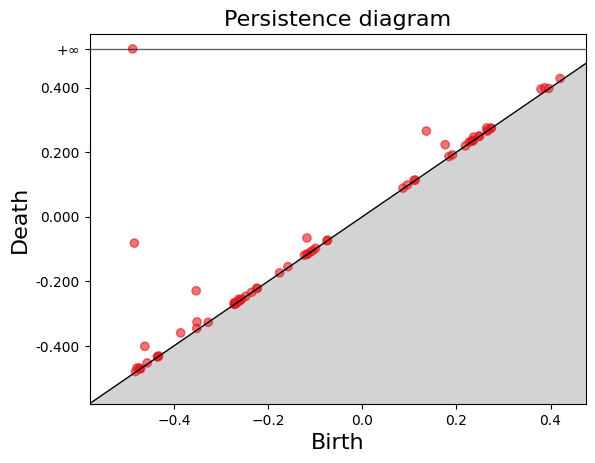

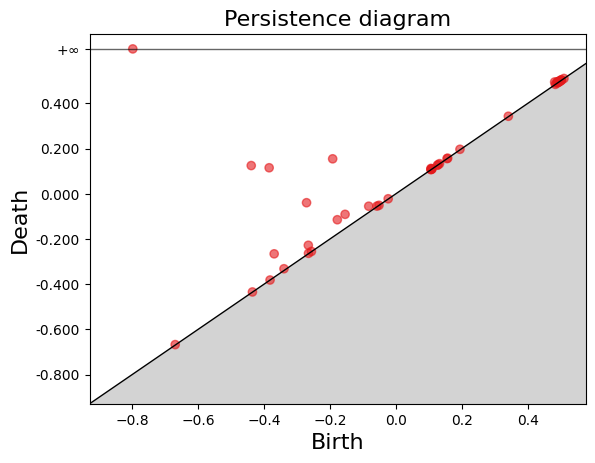

In [80]:
other_index = 20

raw_clean_diagram_bis = dgms_clean[other_index]
raw_little_noisy_diagram_bis = dgms_little_noisy[other_index]
raw_very_noisy_diagram_bis = dgms_very_noisy[other_index]
gd.plot_persistence_diagram(raw_clean_diagram)
gd.plot_persistence_diagram(raw_clean_diagram_bis)
[clean_diagram_bis] = gdr.DiagramSelector(use=True, point_type='finite').fit_transform([raw_clean_diagram_bis])
[little_noisy_diagram_bis] = gdr.DiagramSelector(use=True, point_type='finite').fit_transform([raw_little_noisy_diagram_bis])
[very_noisy_diagram_bis] = gdr.DiagramSelector(use=True, point_type='finite').fit_transform([raw_very_noisy_diagram_bis])

### Question 10.
Get familiar with the [bottleneck](https://gudhi.inria.fr/python/latest/bottleneck_distance_user.html#) and the [Wasserstein](https://gudhi.inria.fr/python/latest/wasserstein_distance_user.html) distances between diagrams. Note that you can call them in different ways in `Gudhi`, there are `bottleneck_distance` and `wasserstein_distance` functions for instance, but there are also wrappers of these functions into estimator classes `BottleneckDistance` and `WassersteinDistance` (with `fit` and `transform` methods). These classes are especially useful when doing model selection with `Scikit-Learn`. We provide below the scikit versions that can be used to compute the distances. Using their `fit` and `transform` methods, compute the distance matrix between all six diagrams (3 versions for initially selected diagram and 3 versions for newly selected diagram) for both metrics (this might take up to a minute)

In [81]:
BD = gdr.BottleneckDistance(epsilon=.001)
WD = gdr.WassersteinDistance(internal_p=2, order=2)

diag_list = [
    clean_diagram, little_noisy_diagram, very_noisy_diagram,
    clean_diagram_bis, little_noisy_diagram_bis, very_noisy_diagram_bis
]

BD_matrix = np.zeros((len(diag_list), len(diag_list)))
for i in range(len(diag_list)):
    for j in range(len(diag_list)):
        BD.fit([diag_list[i]])
        BD_matrix[i, j] = BD.transform([diag_list[j]])[0][0]
WD_matrix = np.zeros((len(diag_list), len(diag_list)))
for i in range(len(diag_list)):
    for j in range(len(diag_list)):
        WD.fit([diag_list[i]])
        WD_matrix[i, j] = WD.transform([diag_list[j]])[0][0]

### Question 11.
Use the function below to display both distance matrices computed above. What do you observe? Which distance seems to better discriminate between the different diagrams while grouping the same diagram with different noise levels? Based on this observation which one would be btter for classification?

In [82]:
def plot_distance_matrices(distance_matrices_dict, diag_names=None):
    """
    Plot distance matrices side by side with proper labels.
    
    Parameters:
    -----------
    distance_matrices_dict : dict
        Dictionary where keys are distance names and values are distance matrices
    diag_names : list, optional
        List of names for the diagrams. If None, uses default names.
    """
    
    # Convert to list for easier handling
    matrix_names = list(distance_matrices_dict.keys())
    matrices = list(distance_matrices_dict.values())
    
    # Default diagram names if not provided
    if diag_names is None:
        matrix_size = matrices[0].shape[0] if matrices else 6
        diag_names = [
            'clean_1', 'little_noisy_1', 'very_noisy_1',
            'clean_2', 'little_noisy_2', 'very_noisy_2'
        ][:matrix_size]
    
    # Process matrices in batches of 2
    num_matrices = len(matrices)
    num_batches = (num_matrices + 1) // 2  # Ceiling division
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * 2
        end_idx = min(start_idx + 2, num_matrices)
        batch_matrices = matrices[start_idx:end_idx]
        batch_names = matrix_names[start_idx:end_idx]
        
        # Determine subplot layout
        num_plots = len(batch_matrices)
        if num_plots == 1:
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            axes = [ax]
        else:
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot each matrix in the current batch
        for i, (matrix, name) in enumerate(zip(batch_matrices, batch_names)):
            ax = axes[i] if num_plots > 1 else axes[0]
            
            # Create heatmap
            im = ax.imshow(matrix, cmap='viridis', interpolation='nearest')
            ax.set_title(f'{name} Matrix', fontsize=14, fontweight='bold')
            ax.set_xlabel('Diagrams', fontsize=12)
            ax.set_ylabel('Diagrams', fontsize=12)
            
            # Set ticks and labels
            ax.set_xticks(range(len(diag_names)))
            ax.set_yticks(range(len(diag_names)))
            ax.set_xticklabels(diag_names, rotation=45, ha='right')
            ax.set_yticklabels(diag_names)
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('Distance', fontsize=11)
            
            # Add text annotations
            for row in range(len(diag_names)):
                for col in range(len(diag_names)):
                    text_color = "white" if matrix[row, col] > matrix.max()/2 else "black"
                    ax.text(col, row, f'{matrix[row, col]:.3f}',
                           ha="center", va="center", color=text_color, fontsize=9)
        
        # Hide unused subplot if only one matrix in this batch
        if num_plots == 1 and len(axes) > 1:
            axes[1].set_visible(False)
        
        plt.tight_layout()
        plt.show()

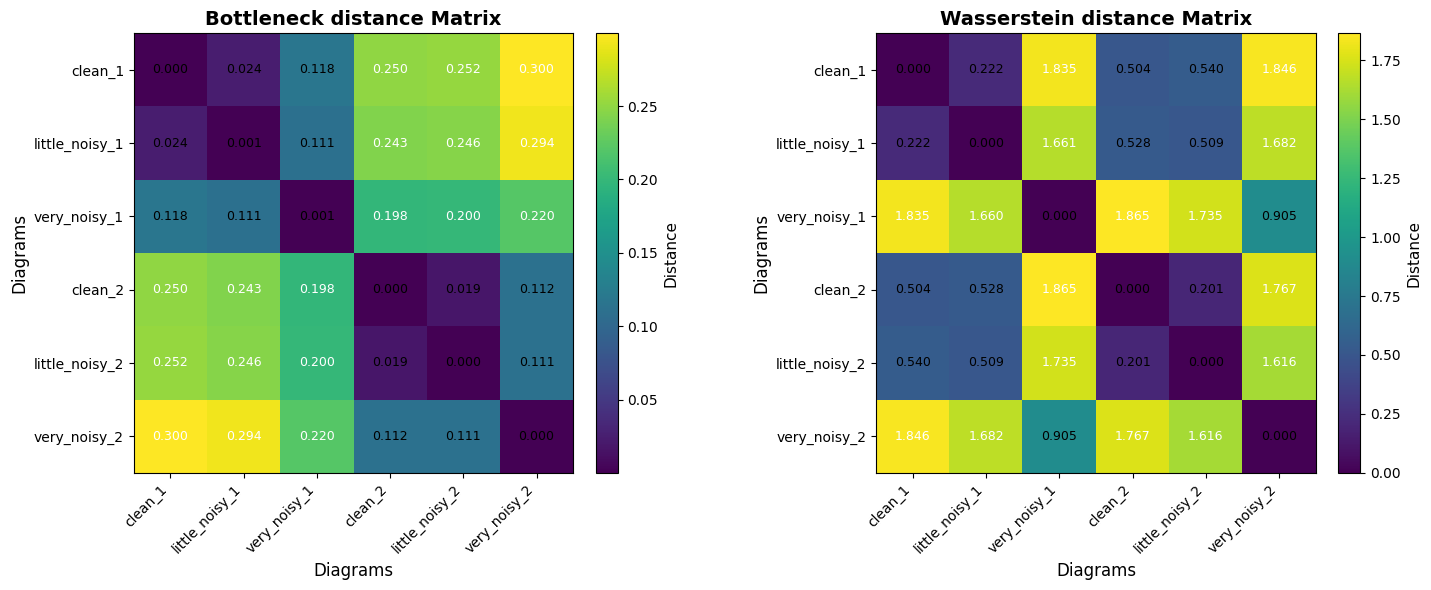

In [83]:
# Create the visualization with your computed matrices
distance_dict = {
    'Bottleneck distance': BD_matrix,
    'Wasserstein distance': WD_matrix
}
plot_distance_matrices(distance_dict)

### Question 12.
`Gudhi` also allows to use standard kernels such as, among others, the [persistence scale space kernel](https://gudhi.inria.fr/python/latest/representations.html#gudhi.representations.kernel_methods.PersistenceScaleSpaceKernel), [persistence Fisher kernel](https://gudhi.inria.fr/python/latest/representations.html#gudhi.representations.kernel_methods.PersistenceFisherKernel), [sliced Wasserstein kernel](https://gudhi.inria.fr/python/latest/representations.html#gudhi.representations.kernel_methods.SlicedWassersteinKernel), etc. Compute the distance matrices associated to each one of these kernels.


**Warning: In the case of PSS, apply the function PSS_matrix_transform to the similarity matrix to normalize it**

In [45]:
PSS = gd.representations.PersistenceScaleSpaceKernel(bandwidth=1.)
PF = gd.representations.PersistenceFisherKernel(bandwidth_fisher=.1, bandwidth=.1, kernel_approx=None)
SW = gd.representations.SlicedWassersteinKernel(bandwidth=1, num_directions=100)
def PSS_matrix_transform(PSS_matrix):
    # Exract diagonal from matrix
    diag = np.diag(PSS_matrix)
    normalizers = 1 / np.sqrt(diag[:,None] * diag[None,:])
    return PSS_matrix * normalizers

PSS_matrix = np.zeros((len(diag_list), len(diag_list)))
for i in range(len(diag_list)):
    for j in range(len(diag_list)):
        PSS.fit([diag_list[i]])
        PSS_matrix[i, j] = PSS.transform([diag_list[j]])[0][0]
PSS_matrix = PSS_matrix_transform(PSS_matrix)
PF_matrix = np.zeros((len(diag_list), len(diag_list)))
for i in range(len(diag_list)):
    for j in range(len(diag_list)):
        PF.fit([diag_list[i]])
        PF_matrix[i, j] = PF.transform([diag_list[j]])[0][0]
SW_matrix = np.zeros((len(diag_list), len(diag_list)))
for i in range(len(diag_list)):
    for j in range(len(diag_list)):
        SW.fit([diag_list[i]])
        SW_matrix[i, j] = SW.transform([diag_list[j]])[0][0]

### Question 13.
Kernel methods act similarly as distance, but instead of providing a distance noion between elements, they provide a similarity measure. In other words the value would be maximal when comparnig two identical objects. Using again the function `plot_distance_matrices`, compare the behavior of the different kernels. What do you observe?

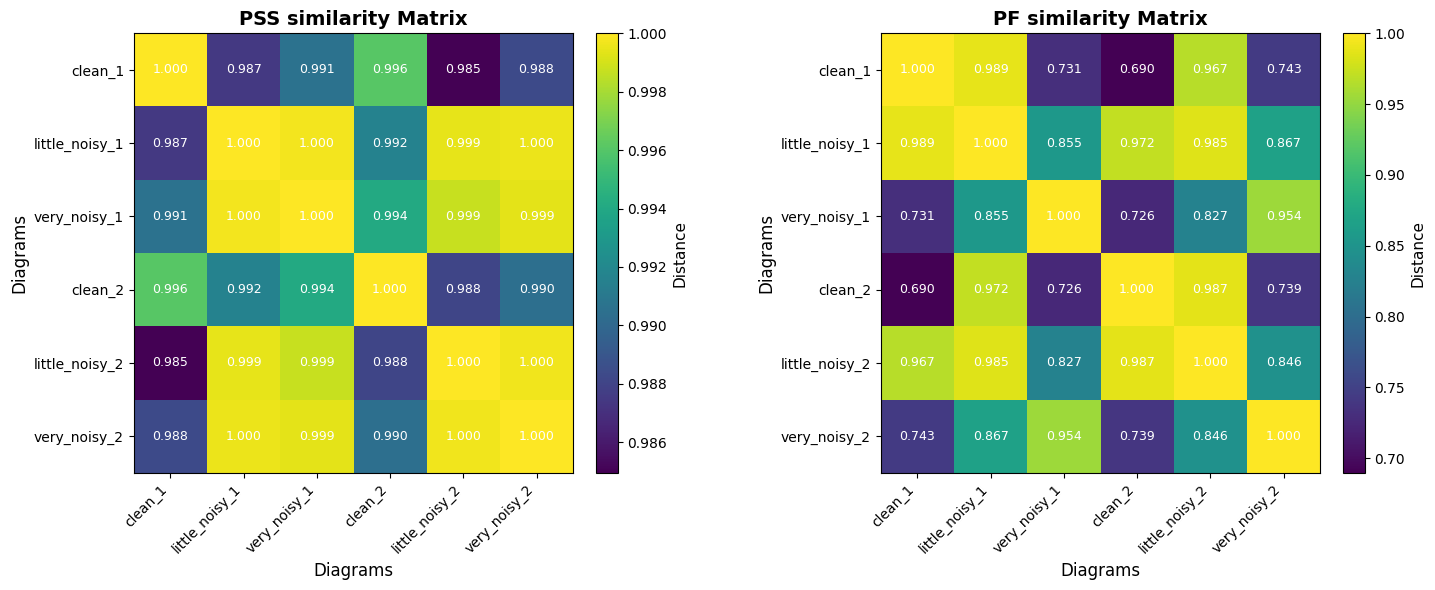

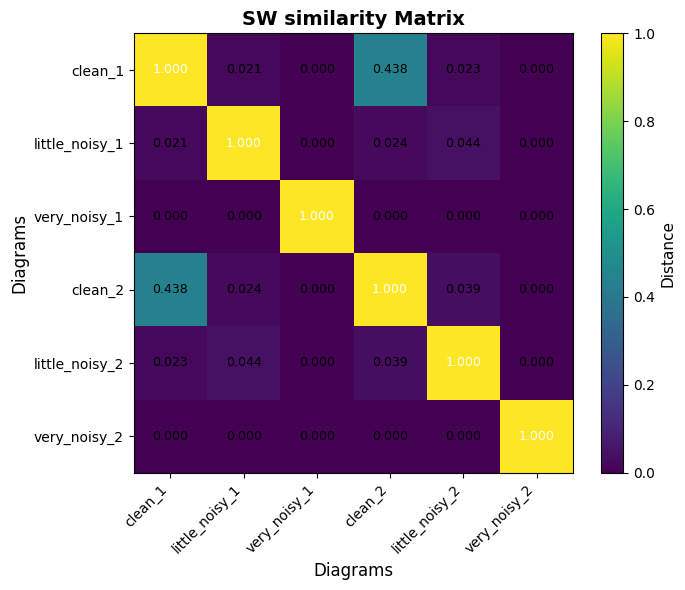

In [46]:
similariy_matrices = {
    'PSS similarity': PSS_matrix,
    'PF similarity': PF_matrix,
    'SW similarity': SW_matrix
}
plot_distance_matrices(similariy_matrices)

### Question 15.

Before trying to classify the persistence diagrams, let's do a quick dimension reduction with PCA. Apply `PCA`, `KernelPCA` or `MDS` (available in `Scikit-Learn`) on the explicit maps (landscapes, images, etc), kernel matrices (Fisher, sliced Wasserstein, etc) and distance matrices (bottleneck, Wasserstein, etc) respectively.

In [47]:
def compare_dimension_reduction(dgms, labels, label_encoder):
    silhouettes        = gdr.Silhouette(resolution=1000, weight=lambda x: np.power(x[1]-x[0],0)).fit_transform(dgms)
    sliced_wass_kernel = gdr.SlicedWassersteinKernel(num_directions=100).fit_transform(dgms)
    bottleneck_matrix  = gdr.BottleneckDistance().fit_transform(dgms)

    pca_silhouettes         = skd.PCA(n_components=2).fit_transform(silhouettes)
    kpca_sliced_wass_kernel = skd.KernelPCA(n_components=2).fit_transform(sliced_wass_kernel)
    mds_bottleneck_matrix   = skf.MDS(n_components=2, dissimilarity='precomputed').fit_transform(bottleneck_matrix)

    integer_labels = label_encoder.transform(labels)
    label_indices = [(l,label_encoder.classes_[l],np.argwhere(integer_labels==l).ravel()) for l in range(integer_labels.max()+1)]

    plt.figure(figsize=(10,5))
    ax1 = plt.subplot(131)
    for il,l,li in label_indices:
        ax1.scatter(pca_silhouettes[li,0], pca_silhouettes[li,1], label=l)
    ax1.legend()
    ax1.set_title('Silhouette')
    ax2 = plt.subplot(132)
    for il,l,li in label_indices:
        ax2.scatter(kpca_sliced_wass_kernel[li,0], kpca_sliced_wass_kernel[li,1], label=l)
    ax2.legend()
    ax2.set_title('SWK')
    ax3 = plt.subplot(133)
    for il,l,li in label_indices:
        ax3.scatter(mds_bottleneck_matrix[li,0], mds_bottleneck_matrix[li,1], label=l)
    ax3.legend()
    ax3.set_title('Bottleneck')
    plt.show()

/home/alejandro/These/.venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9.



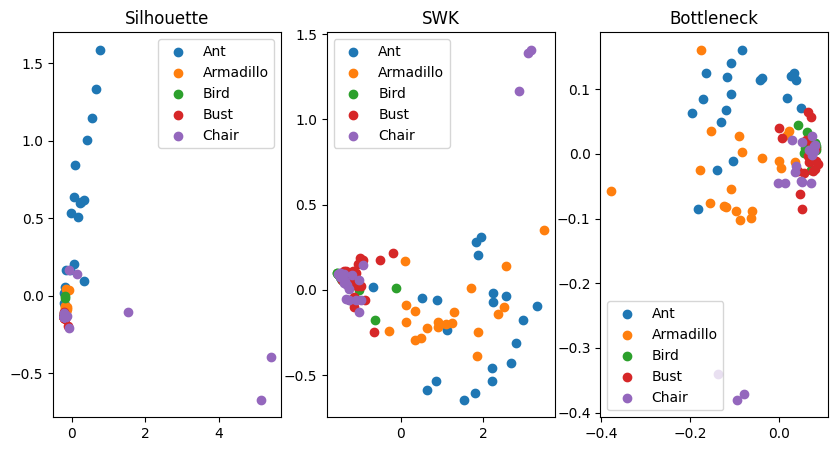

In [48]:
compare_dimension_reduction(gdr.DiagramSelector(use=True, point_type='finite').fit_transform(dgms_clean), labels_clean, le_clean)

Is there any method that looks better in separating the categories, at least by eye?

### Question 17.

All right, let's try classification now! The best thing about having estimator-like classes is that they can be integrated flawlessly in a `Pipeline` of `Scikit-Learn` for model selection and cross-validation! A `Pipeline` is itself an estimator, and is initialized as with a list of estimators. It will just sequentially apply the `fit_transform` methods of the estimators in the list.

Here is a snippet that shuffles the data, creates a random 80/20 train/test split, and trains a classification model integrated in a `Pipeline` instance. This sickit API makes it particularly easy to plug preprocessing steps, feature extraction 

In [49]:
np.random.seed(0)

labels = labels_clean
dgms = dgms_clean

test_size            = 0.2
perm                 = np.random.permutation(len(labels))
limit                = int(test_size * len(labels))
test_sub, train_sub  = perm[:limit], perm[limit:]
train_labs           = np.array(labels)[train_sub]
test_labs            = np.array(labels)[test_sub]
train_dgms           = [dgms[i] for i in train_sub]
test_dgms            = [dgms[i] for i in test_sub]

pipe = skl.Pipeline([("Separator", gdr.DiagramSelector(use=True, limit=np.inf, point_type="finite")),
                     ("Scaler",    gdr.DiagramScaler(use=True, scalers=[([0,1], skp.MinMaxScaler())])),
                     ("TDA",       gdr.SlicedWassersteinKernel(bandwidth=0.1, num_directions=20)),
                     ("Estimator", sks.SVC(kernel="precomputed", gamma="auto"))])

model = pipe.fit(train_dgms, train_labs)

print("Train accuracy = " + str(model.score(train_dgms, train_labs)))
print("Test accuracy  = " + str(model.score(test_dgms,  test_labs)))

Train accuracy = 0.9
Test accuracy  = 0.7


Change the above snippet by modifying the `TDA` and `Estimator` elements and parameters to try to improve the test accuracy, based on all the embedding methods seen earlier. Here are a few classifiers you can try insead of the `SVC`
```python
ske.RandomForestClassifier()
skn.KNeighborsClassifier(metric="precomputed")
```


In [50]:
np.random.seed(0)

labels = labels_clean
dgms = dgms_clean

test_size            = 0.2
perm                 = np.random.permutation(len(labels))
limit                = int(test_size * len(labels))
test_sub, train_sub  = perm[:limit], perm[limit:]
train_labs           = np.array(labels)[train_sub]
test_labs            = np.array(labels)[test_sub]
train_dgms           = [dgms[i] for i in train_sub]
test_dgms            = [dgms[i] for i in test_sub]

pipe = skl.Pipeline([("Separator", gdr.DiagramSelector(use=True, limit=np.inf, point_type="finite")),
                     ("TDA",       gdr.Silhouette(resolution=100)),
                     ("Estimator", ske.RandomForestClassifier())])

model = pipe.fit(train_dgms, train_labs)

print("Train accuracy = " + str(model.score(train_dgms, train_labs)))
print("Test accuracy  = " + str(model.score(test_dgms,  test_labs)))

Train accuracy = 1.0
Test accuracy  = 0.8


### Question 18.
The snippet below automates the search for the best embedding and estimator by defining the general pipeline structure, and providing a list of configurations that will be tested using cross validation. See the [documentation](https://scikit-learn.org/stable/modules/compose.html#combining-estimators).
Run the snippet, observe what parameters perform best and their corresponding test accuracy.

In [51]:
pipe = skl.Pipeline([("Separator", gdr.DiagramSelector(use=True, limit=np.inf, point_type="finite")),
                     ("Scaler",    gdr.DiagramScaler(use=True, scalers=[([0, 1], skp.MinMaxScaler())])),
                     ("TDA",       gdr.Silhouette(resolution=100)),
                     ("Estimator", ske.RandomForestClassifier())])

param =    [{"Scaler__use":         [False, True],
             "TDA":                 [gdr.SlicedWassersteinKernel()], 
             "TDA__bandwidth":      [0.1, 1.0],
             "TDA__num_directions": [20],
             "Estimator":           [sks.SVC(kernel="precomputed", gamma="auto")]},
                        
            {"Scaler__use":         [False, True],
             "TDA":                 [gdr.Silhouette()], 
             "TDA__resolution":     [100],
             "Estimator":           [ske.RandomForestClassifier()]},
           
            {"Scaler__use":         [False, True],
             "TDA":                 [gdr.BottleneckDistance()], 
             "TDA__epsilon":        [0.1], 
             "Estimator":           [skn.KNeighborsClassifier(metric="precomputed")]}
]

model = skm.GridSearchCV(pipe, param, cv=3)
model = model.fit(train_dgms, train_labs)

print("Train accuracy = " + str(model.score(train_dgms, train_labs)))
print("Test accuracy  = " + str(model.score(test_dgms,  test_labs)))

Train accuracy = 1.0
Test accuracy  = 0.8


How good is your score? How would you improve it? You can also try to use PersLay to learn which representation to use, see this [tutorial](https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-perslay-visu.ipynb). Modify the tested parameters above to try to improve the accuracy. You can also try using the noisy datasets iinstead, but be careful, the preprocessing steps can take much longer!

In [52]:
pipe = skl.Pipeline([("Separator", gdr.DiagramSelector(use=True, limit=np.inf, point_type="finite")),
                     ("Scaler",    gdr.DiagramScaler(use=True, scalers=[([0, 1], skp.MinMaxScaler())])),
                     ("TDA",       gdr.Silhouette(resolution=100)),
                     ("Estimator", ske.RandomForestClassifier())])

param =    [{"Scaler__use":         [False, True],
             "TDA":                 [gdr.SlicedWassersteinKernel()], 
             "TDA__bandwidth":      [0.1, 1.0],
             "TDA__num_directions": [20],
             "Estimator":           [sks.SVC(kernel="precomputed", gamma="auto")]},
                        
            {"Scaler__use":         [False, True],
             "TDA":                 [gdr.Silhouette()], 
             "TDA__resolution":     [100],
             "Estimator":           [ske.RandomForestClassifier()]},
           
            {"Scaler__use":         [False, True],
             "TDA":                 [gdr.BottleneckDistance()], 
             "TDA__epsilon":        [0.1], 
             "Estimator":           [skn.KNeighborsClassifier(metric="precomputed")]}
]

model = skm.GridSearchCV(pipe, param, cv=3)
model = model.fit(train_dgms, train_labs)

print("Train accuracy = " + str(model.score(train_dgms, train_labs)))
print("Test accuracy  = " + str(model.score(test_dgms,  test_labs)))

Train accuracy = 1.0
Test accuracy  = 0.75


## (BONUS) 3D shape statistics with persistence diagrams

In this section, our goal is to compute confidence regions associated to the persistence diagram of a given 3D shape. We will study such regions for both the persistence diagram, and one of its representation, the persistence landscape. 

Let's first pick a 3D shape. For instance, use `Hand/181.off` (or any other one you would like to try).

In [100]:
vertices, faces, label_faces = load_data('Hand', 181)
plot_data(vertices, faces, label_faces)

The first standard way of obtaining confidence regions for (geometric) persistence diagrams is through the stability theorem (see class):

$$\mathbb{P}(d_b(D_{\rm Rips}(X),D_{\rm Rips}(\hat X_n)) \geq \delta)\leq \mathbb{P}(d_H(X,\hat X_n)\geq \delta/2),$$
$$\mathbb{P}(d_b(D_{\rm Cech}(X),D_{\rm Cech}(\hat X_n)) \geq \delta)\leq \mathbb{P}(d_H(X,\hat X_n)\geq \delta),$$

where $d_H(\cdot,\cdot)$ is the Hausdorff distance, defined, for any two compact spaces $X,Y\subset \mathbb{R}^d$, as 

$$d_H(X,Y)={\rm min}\{{\rm max}_{x\in X}{\rm min}_{y\in Y}\|x-y\|, {\rm max}_{y\in Y}{\rm min}_{x\in X}\|y-x\|\}.$$

Hence, it suffices to estimate $\mathbb{P}(d_H(X,\hat X_n)\geq \delta)$ in order to derive confidence regions for persistence diagrams. There exists an upper bound for this probability when $\hat X_n$ is drawn from an $(a,b)$-standard probability measure, however this bound depends on $a$ and $b$. In the following, we will rather use the subsampling method, that allows to estimate the probability solely from subsampling $\hat X_n$ with $s(n) =o\left(\frac{n}{{\rm log}(n)}\right)$ points, and computing $d_H(\hat X_n, \hat X_{s(n)})$. The exact procedure is described in Section 4.1 in [this article](file:///user/mcarrier/home/Downloads/14-AOS1252.pdf).

Write a function `hausdorff_distance` that computes the Hausdorff distance between the vertices of our 3D shape and a subset of these vertices.

In [101]:
def hausdorff_distance(vertices, sn):
    n = len(vertices)
    I = np.random.choice(n, sn, replace=False)
    Icomp = np.setdiff1d(np.arange(n), I)
    tree = skn.KDTree(vertices[I], leaf_size=2)
    distances, _ = tree.query(vertices[Icomp], k=1) 
    hdist = max(distances)
    return(hdist)

Now, write a function `hausdorff_interval` that computes this Hausdorff distance many times and uses the corresponding distribution of Hausdorff distances in order to output the bottleneck distance value associated to a given confidence level (by computing the quantile---corresponding to this confidence level---of the distribution).

In [102]:
def hausdorff_interval(vertices, level=0.95, sn=100, N=1000):
    distribution_hausdorff_distances = [hausdorff_distance(vertices, sn) for _ in range(N)]
    diagram_quantile = np.quantile(distribution_hausdorff_distances, level)
    return diagram_quantile

Apply your code to obtain a bottleneck distance associated to, say, 90% confidence.

In [103]:
n = len(vertices)
conf_bottleneck = hausdorff_interval(vertices=vertices, level=0.9, N=100, sn=int(10*n/np.log(n)**2))
print('Bottleneck distance associated to confidence level = ' + str(conf_bottleneck))

Bottleneck distance associated to confidence level = 0.09646033369988014


All right, now let's see which points of the persistence diagram are we going to label non-significant and discard. Compute the Rips and Alpha persistence diagrams of the points. 

In [104]:
simplex_tree = gd.RipsComplex(points=vertices, max_edge_length=9*1e-2).create_simplex_tree(max_dimension=2)
pers_rips = simplex_tree.persistence()

In [105]:
simplex_tree = gd.AlphaComplex(points=vertices).create_simplex_tree()
for splx, filt in simplex_tree.get_filtration():
    simplex_tree.assign_filtration(splx, filtration=np.sqrt(filt))
pers_alpha = simplex_tree.persistence()

Now, visualize the persistence diagrams with a band of size the previously computed bottleneck distance times 2 (for Alpha filtration) and 4 (for Rips filtration).

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

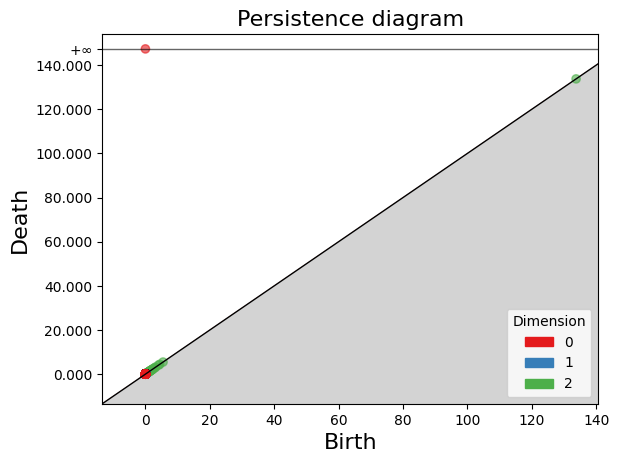

In [106]:
gd.plot_persistence_diagram(pers_alpha, band=2*conf_bottleneck)

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

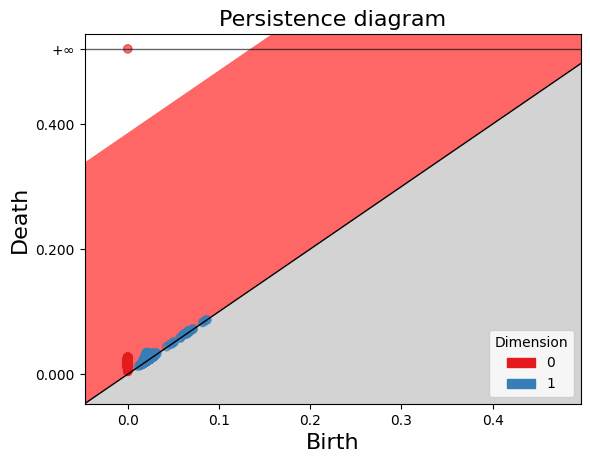

In [107]:
gd.plot_persistence_diagram(pers_rips, band=4*conf_bottleneck)

Are you discarding many points? If yes, this could be because the confidence region is computed only from the stability property of persistence diagrams: subsampling the Hausdorff distance can sometimes be quite conservative. It would be more efficient to bootstrap the persistence diagrams themselves---this is the approach advocated in Section 6 of [this article](https://www.jmlr.org/papers/volume18/15-484/15-484.pdf). However, this method was only proved for persistence diagrams obtained through the sublevel sets of kernel density estimators... But let's try it anyway! ;-)

Similarly than before, write `bottleneck_distance_bootstrap` and `bottleneck_interval` functions that compute the bottleneck distances between our current persistence diagram (in homology dimension 1) and the persistence diagrams of many bootstrap iterates.

In [108]:
dgm = simplex_tree.persistence_intervals_in_dimension(1)

In [109]:
def bottleneck_distance_bootstrap(dgm, vertices):
    n = len(vertices)
    I = np.random.choice(n, n, replace=True)
    simplex_tree = gd.AlphaComplex(points=vertices[I]).create_simplex_tree()
    for splx, filt in simplex_tree.get_filtration():
        simplex_tree.assign_filtration(splx, filtration=np.sqrt(filt))
    simplex_tree.persistence()
    dgm_subsample = simplex_tree.persistence_intervals_in_dimension(1)
    return gd.bottleneck_distance(dgm, dgm_subsample)

In [110]:
def bottleneck_interval(dgm, vertices, level=0.95, N=1000):
    distribution_bottleneck_distances = [bottleneck_distance_bootstrap(dgm, vertices) for _ in range(N)]
    bottleneck_diagram_quantile = np.quantile(distribution_bottleneck_distances, level)
    return bottleneck_diagram_quantile

Compute the bottleneck distance associated to a confidence level and visualize it.

In [111]:
n = len(vertices)
conf_bottleneck_empirical = bottleneck_interval(dgm=dgm, vertices=vertices, level=0.9, N=100)
print('Bottleneck distance associated to confidence level = ' + str(conf_bottleneck_empirical))

Bottleneck distance associated to confidence level = 0.013937604946486762


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

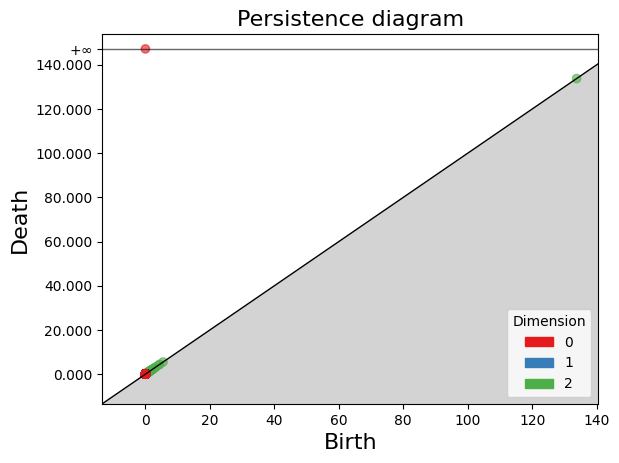

In [112]:
gd.plot_persistence_diagram(pers_alpha, band=2*conf_bottleneck_empirical)

Are you discarding less points in the persistence diagram now?

Another approach with more theoretical guarantees is to use the persistence landscapes associated to the persistence diagram. Indeed, valid confidence regions can be easily obtained using, e.g., algorithm 1 in [this article](https://geometrica.saclay.inria.fr/team/Fred.Chazal/papers/cflrw-scpls-14/cflrw-scpls-14.pdf). In the following, we will fix a subsample size $s(n)$, and estimate $\mathbb{E}[\Lambda_{s(n)}]$, where $\Lambda_{s(n)}$ is the landscape of a random subsample of size $s(n)$ (i.e., drawn from a probability measure $\mu$ such as, e.g., the empirical measure). 

Let's first make sure that we can compute landscapes ;-) Use `Gudhi` to compute and plot the first six persistence landscapes associated to the persistence diagram computed above in homology dimension 1. Landscapes (and other vectorizations) are implemented with the API of `Scikit-Learn` estimators, which means that you have to call the `fit_transform` method on a list of persistence diagrams in order to get their landscapes. 

In [113]:
dgm1 = simplex_tree.persistence_intervals_in_dimension(1)

In [114]:
landscape1 = gdr.Landscape(num_landscapes=6, resolution=100).fit_transform([dgm1])

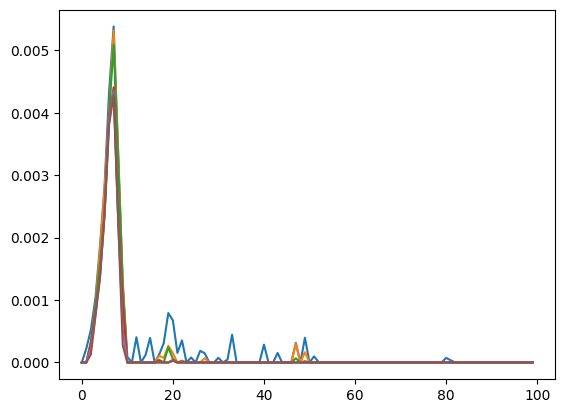

In [115]:
plt.figure()
plt.plot(landscape1[0,0:100])
plt.plot(landscape1[0,100:200])
plt.plot(landscape1[0,200:300])
plt.plot(landscape1[0,300:400])
plt.plot(landscape1[0,400:500])
plt.plot(landscape1[0,500:600])
plt.show()

Write a function `landscape_interval` that implements the landscape bootstrap procedure, that is, drawing many subsamples of size $s(n)$, computing their Alpha persistence diagrams and landscapes, computing the distribution of distances between each single landscape and their mean (multiplied by a random normal variable), and finally using the quantiles of this distribution in order to obtain confidence regions for the mean landscape.

In [119]:
def landscape_interval(vertices, sn=100, N=100, B=100, num_landscapes=6, resolution=100, landscape_estimator=None):
    n = len(vertices)
    
    list_sub_dgm = []
    for _ in range(N):
        sub_vertices = vertices[np.random.choice(n, sn, replace=True)]
        sub_simplex_tree = gd.AlphaComplex(points=sub_vertices).create_simplex_tree()
        for splx, filt in sub_simplex_tree.get_filtration():
            sub_simplex_tree.assign_filtration(splx, filtration=np.sqrt(filt))
        sub_simplex_tree.persistence()
        sub_dgm = sub_simplex_tree.persistence_intervals_in_dimension(1)
        list_sub_dgm.append(sub_dgm)
    
    if landscape_estimator is None:
        landscape_estimator = gdr.Landscape(num_landscapes=num_landscapes, resolution=resolution).fit(list_sub_dgm)
    
    landscape_distrib = landscape_estimator.transform(list_sub_dgm)
    mean_landscape = np.mean(landscape_distrib, axis=0)
    landscape_differences = landscape_distrib - mean_landscape[None,:]
    
    theta_distrib = [[] for _ in range(num_landscapes)]
    for _ in range(B):
        xi = np.random.normal(size=[N,1])
        random_landscape_differences = np.abs(np.multiply(xi, landscape_differences).sum(axis=0))/np.sqrt(N)
        for nl in range(num_landscapes):
            theta_distrib[nl].append( random_landscape_differences[nl*resolution:(nl+1)*resolution].max() )
    
    return landscape_estimator, mean_landscape, theta_distrib

Apply and visualize the confidence interval around the different landscapes.

In [120]:
N, B, num_landscapes, resolution = 100, 100, 6, 100

In [121]:
landscape_estimator, mean_landscape, theta_distrib = landscape_interval(vertices, sn=int(.9*len(vertices)), 
                                                                        N=N, B=B, num_landscapes=num_landscapes, 
                                                                        resolution=resolution)
q_alpha = [np.quantile(theta_distrib[nl], .9) for nl in range(num_landscapes)]

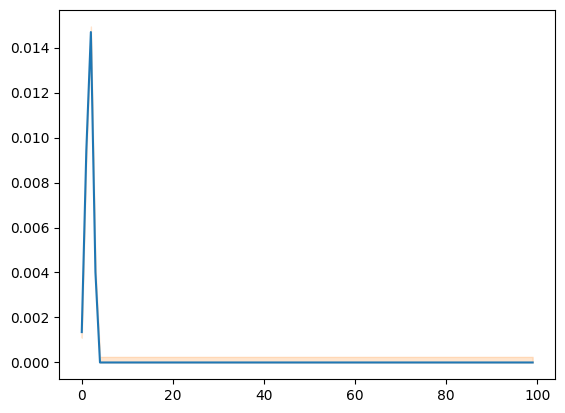

In [122]:
nl = 5

mean_curve  = mean_landscape[nl*resolution:(nl+1)*resolution]
upper_curve = mean_curve+q_alpha[nl]/np.sqrt(N)
lower_curve = np.maximum(0,mean_curve-q_alpha[nl]/np.sqrt(N))

plt.figure()
plt.plot(mean_curve)
plt.fill_between(np.arange(resolution), lower_curve, upper_curve, alpha=0.2, color='tab:orange')
plt.show()

The confidence regions are much better now!

Another interesting property of mean landscapes is their robustness to noise:

$$\|\mathbb{E}[\Lambda_{s(n)}^X]-\mathbb{E}[\Lambda_{s(n)}^Y]\|_\infty\leq 2 \cdot s(n) \cdot d_{GW}(\mu,\nu),$$

where $d_{GW}$ is the 1-Gromov-Wasserstein distance between probability measures. See Remark 6 in [this article](https://geometrica.saclay.inria.fr/team/Fred.Chazal/papers/cflmrw-smph-15/ICMLFinal.pdf). We will now confirm this by adding outlier noise to the 3D shape and looking at the resulting mean landscape.  

Create a noisy version of `vertices` with some outlier noise.

In [123]:
num_noisy_points = 100
np.random.seed(0)
noisy_vertices = np.vstack([vertices, np.random.uniform(vertices.min(), vertices.max(), [num_noisy_points,3])])

Let's first compare the persistence landscapes of the two sets of vertices. Compute and visualize these landscapes on the same plot.

In [124]:
simplex_tree = gd.AlphaComplex(points=vertices).create_simplex_tree()
for splx, filt in simplex_tree.get_filtration():
    simplex_tree.assign_filtration(splx, filtration=np.sqrt(filt))
simplex_tree.persistence()
dgm1 = simplex_tree.persistence_intervals_in_dimension(1)

In [125]:
noisy_simplex_tree = gd.AlphaComplex(points=noisy_vertices).create_simplex_tree()
for splx, filt in noisy_simplex_tree.get_filtration():
    noisy_simplex_tree.assign_filtration(splx, filtration=np.sqrt(filt))
noisy_simplex_tree.persistence()
noisy_dgm1 = noisy_simplex_tree.persistence_intervals_in_dimension(1)

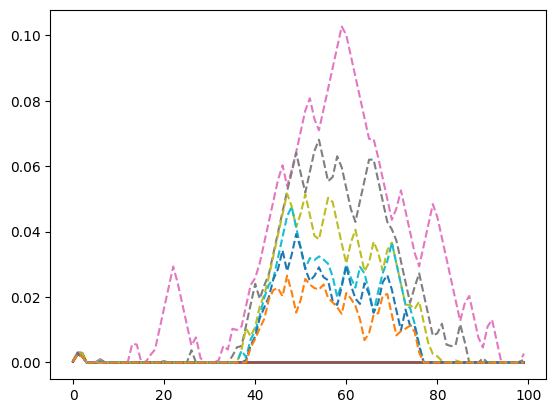

In [126]:
landscape1 = gdr.Landscape(num_landscapes=6, resolution=100).fit_transform([dgm1, noisy_dgm1])
plt.figure()
plt.plot(landscape1[0,0:100])
plt.plot(landscape1[0,100:200])
plt.plot(landscape1[0,200:300])
plt.plot(landscape1[0,300:400])
plt.plot(landscape1[0,400:500])
plt.plot(landscape1[0,500:600])

plt.plot(landscape1[1,0:100],   linestyle='--')
plt.plot(landscape1[1,100:200], linestyle='--')
plt.plot(landscape1[1,200:300], linestyle='--')
plt.plot(landscape1[1,300:400], linestyle='--')
plt.plot(landscape1[1,400:500], linestyle='--')
plt.plot(landscape1[1,500:600], linestyle='--')

plt.show()

As one can see, they are quite different. By contrast, computing the mean landscape with subsamples is much more robust, as we will now see.

Compute the mean persistence landscape of the noisy point cloud, and visualize it next to the mean persistence landscape of the clean point cloud.

In [127]:
_, noisy_mean_landscape, noisy_theta_distrib = landscape_interval(noisy_vertices, sn=int(.9*len(vertices)), 
                                                               N=N, B=B, num_landscapes=num_landscapes, 
                                                               resolution=resolution,
                                                               landscape_estimator=landscape_estimator)
noisy_q_alpha = [np.quantile(noisy_theta_distrib[nl], .9) for nl in range(num_landscapes)]

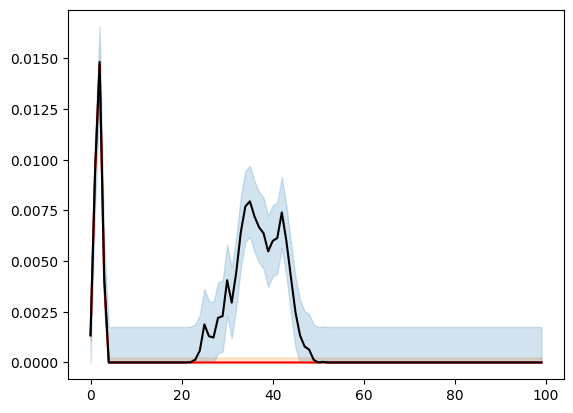

In [128]:
nl = 5

mean_curve  = mean_landscape[nl*resolution:(nl+1)*resolution]
upper_curve = mean_curve+q_alpha[nl]/np.sqrt(N)
lower_curve = np.maximum(0,mean_curve-q_alpha[nl]/np.sqrt(N))

noisy_mean_curve  = noisy_mean_landscape[nl*resolution:(nl+1)*resolution]
noisy_upper_curve = noisy_mean_curve+noisy_q_alpha[nl]/np.sqrt(N)
noisy_lower_curve = np.maximum(0,noisy_mean_curve-noisy_q_alpha[nl]/np.sqrt(N))

plt.figure()
plt.plot(mean_curve, c='red')
plt.fill_between(np.arange(resolution), lower_curve, upper_curve, alpha=0.2, color='tab:orange')
plt.plot(noisy_mean_curve, c='black')
plt.fill_between(np.arange(resolution), noisy_lower_curve, noisy_upper_curve, alpha=0.2, color='tab:blue')
plt.show()